# 데이터 증강
## 목적 : 
### 방법 및 근거
- 1. CenterCrop
- 2. CHALE
- 3. RandomBrightnessContrast
- 4. GaussNoise
- 5. ColorJitter 

In [1]:
import os
import cv2
import numpy as np
import pandas as pd 
from tqdm import tqdm
from PIL import Image
import albumentations as A
import matplotlib.pyplot as plt


6it [00:00, 47.72it/s]


종료


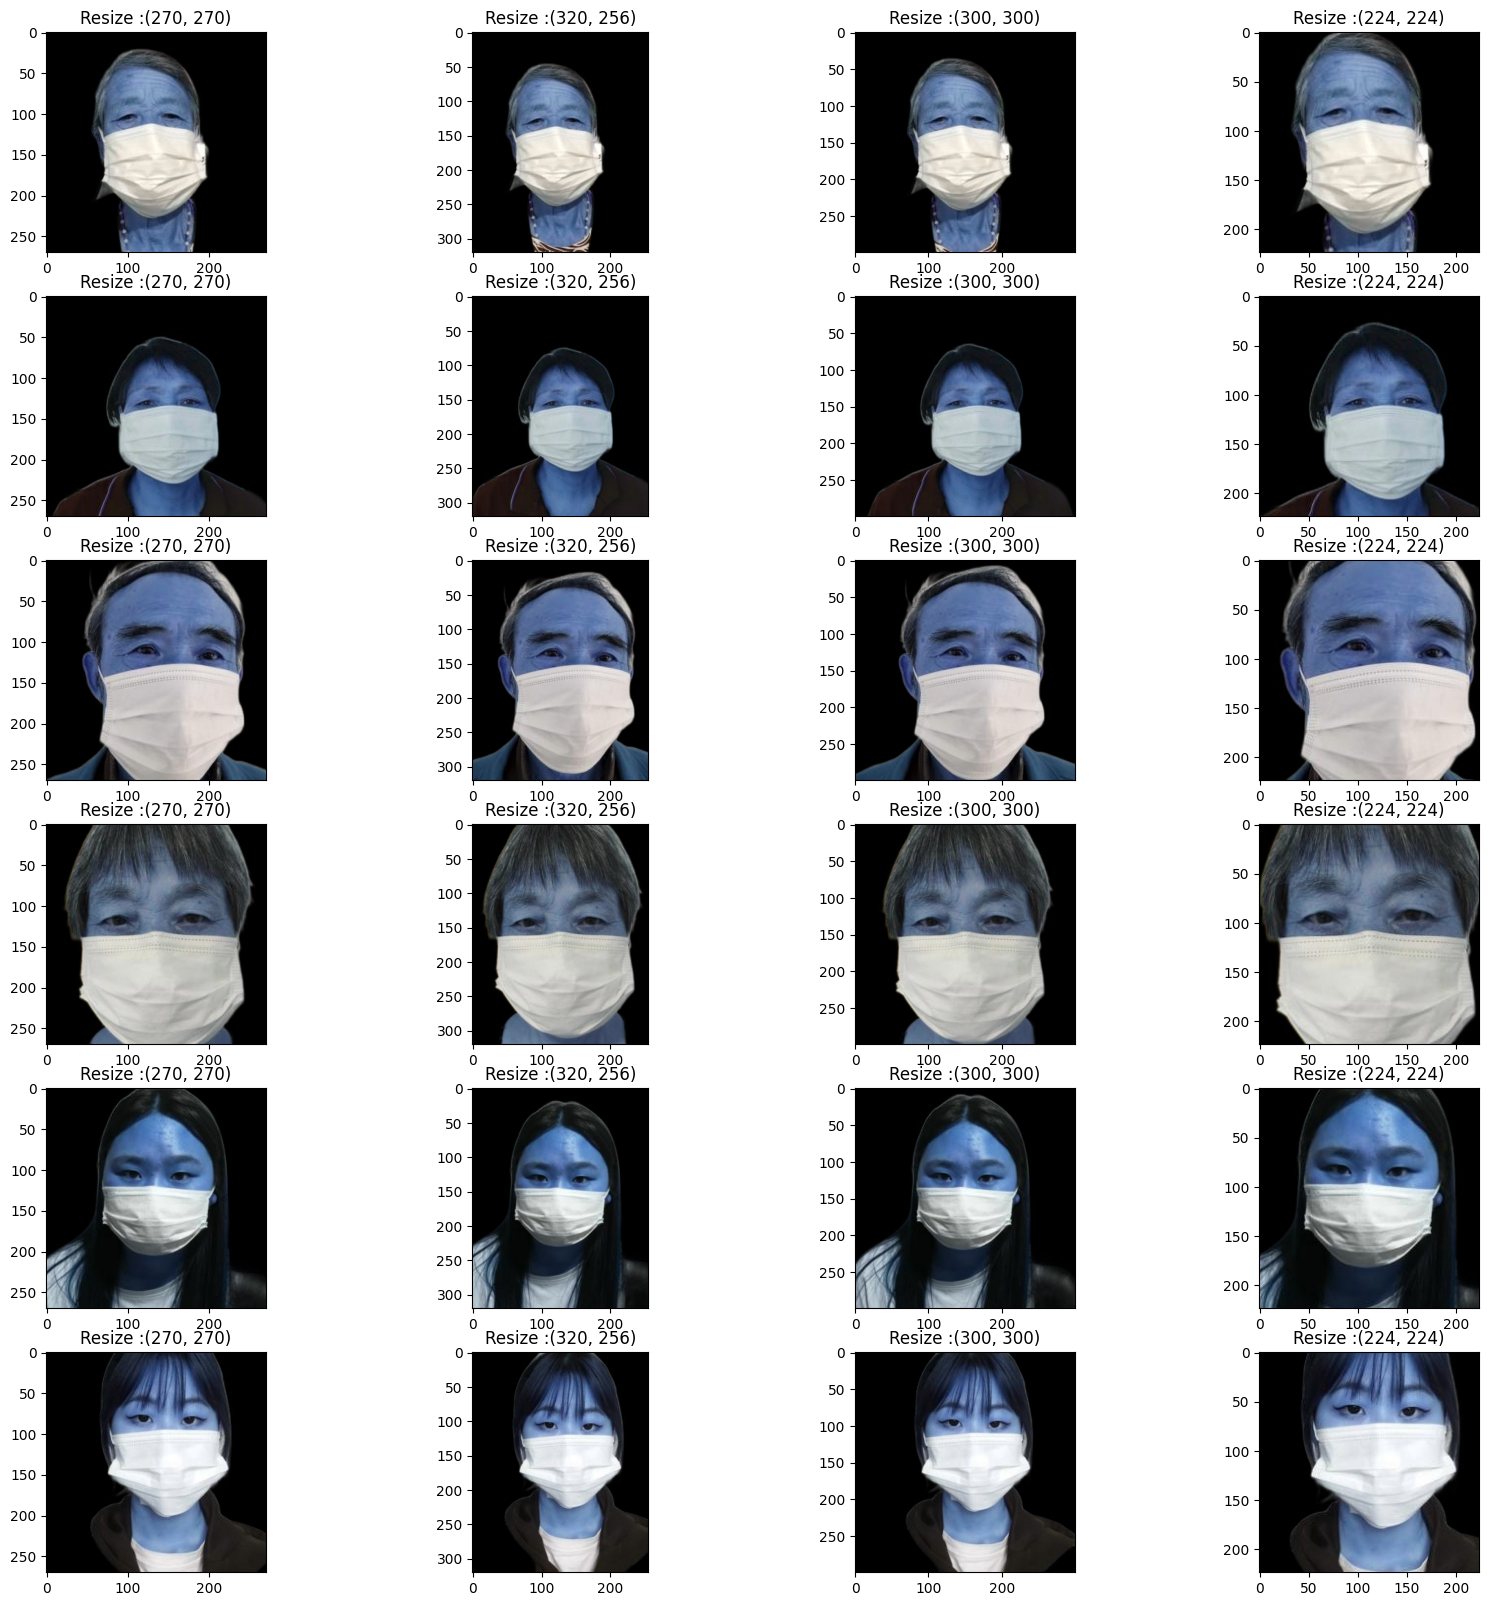

In [11]:
# 적절한 Center crop의 설정
def DecisionCenterCrop(top_level_folder:str, resizes:list, start:int, end:int, want_state:str):
    folders = os.listdir(top_level_folder)[start : end + 1]
    l = len(folders)
    fig, axs = plt.subplots(ncols=len(resizes), nrows=l, figsize=(20, 20))
    # top_level_folder : 최상위 폴더를 넣어주세요!  ex) "images_rembg(original)" / 000001_female_Asian_45 ... / mask1.jpg
    # 전부 보면 너무 많으므로 slicing을 활용해주세요!
    # img_folder ex) 000001_female_Asian_45
    for idx_r, img_folder in tqdm(enumerate(folders)):
        # img ex) mask1.jpg
        for img in os.listdir(os.path.join(top_level_folder, img_folder)):
            state, ext = os.path.splitext(img)
            if state == want_state:
                for idx_c, resize_tup in enumerate(resizes):
                    
                    transform = A.Compose([    
                    A.CenterCrop(resize_tup[0],resize_tup[1]),
                    # A.Resize(512, 384, interpolation=cv2.INTER_LANCZOS4),
                    A.HorizontalFlip(p=1),])
                    
                    pillow_image = Image.open(os.path.join(top_level_folder,  img_folder, img))
                    
                    image = np.array(pillow_image)

                    transformed = transform(image=image)
                    transformed_image = transformed["image"]
                    image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
                    
                    axs[idx_r, idx_c].imshow(image, cmap='gray')
                    axs[idx_r, idx_c].set_title(f"Resize :{resize_tup[0], resize_tup[1]}")
            
    return "종료"
# 0<= start < end < 2701
# want_state = ["normal", "mask1", "maks2", "mask3", "mask4", "mask5", "incorrect-mask"]
print(DecisionCenterCrop(top_level_folder="/Users/ryan/mask classification/aug_dataset/images_rembg(original)",
                    resizes= [(270, 270), (320, 256), (300, 300), (224, 224)],
                    start= 2695, end= 2700, want_state="mask3")
)

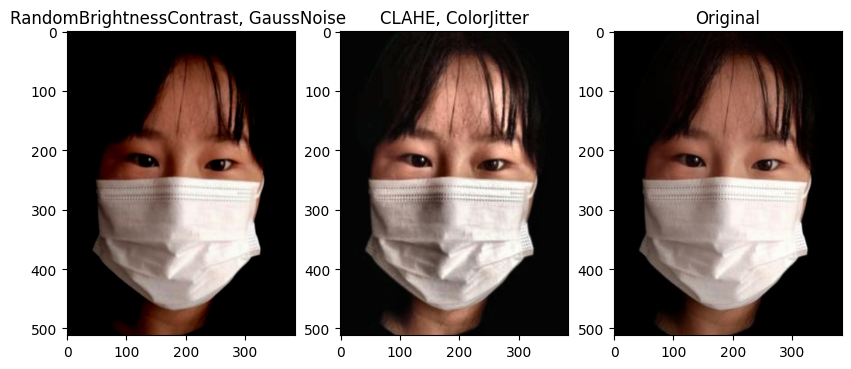

In [2]:
transform0 = A.Compose([    
    A.CenterCrop(320,256),
    A.Resize(512, 384, interpolation=cv2.INTER_LANCZOS4),
    A.HorizontalFlip(p=1),])

transform1 = A.Compose([    
    A.CenterCrop(320, 256),
    A.Resize(512, 384),
    A.HorizontalFlip(p=1),
    A.OneOf([
            A.RandomBrightnessContrast(p=1),
            A.GaussNoise(p=1),], p=1),])

transform2 = A.Compose([    
    A.CenterCrop(320, 256), 
    A.Resize(512, 384),
    A.HorizontalFlip(p=1),
    A.OneOf([
            A.CLAHE(p=1),
            A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=1),])


pillow_image = Image.open(f"/Users/ryan/mask classification/mask3.jpg")

image = np.array(pillow_image)

transformed1 = transform1(image=image)
transformed_image1 = transformed1["image"]
# image1 = cv2.cvtColor(transformed_image1, cv2.COLOR_BGR2RGB)

transformed2 = transform2(image=image)
transformed_image2 = transformed2["image"]
# image2 = cv2.cvtColor(transformed_image2, cv2.COLOR_BGR2RGB)

original = transform0(image=image)
original = original["image"]

# subplot을 사용하여 이미지 양옆으로 띄우기
fig, axs = plt.subplots(1, 3, figsize=(10, 30))
axs[0].imshow(transformed_image1, cmap='gray')
axs[0].set_title(f"RandomBrightnessContrast, GaussNoise ")
axs[1].imshow(transformed_image2, cmap='gray')
axs[1].set_title(f"CLAHE, ColorJitter")
axs[2].imshow(original, cmap="gray")
axs[2].set_title(f"Original")


plt.show()

### 데이터 수 증가 - 실제 적용 코드

In [1]:
import os
import cv2
import numpy as np
import pandas as pd 
from PIL import Image
import albumentations as A

# 특정 dir의 age를 기준으로 한 path를 뽑아내는 함수
def AgePath(read_folder:str, want_age:list):
    img_paths = []
    for wa in want_age:
    # path : 000001_female_Asian_45
        for path in os.listdir(read_folder):
        
            try:
                age = int(path.split("_")[-1])
            except ValueError:
                continue
            
            if age == wa:
                img_paths.append(os.path.join(read_folder, path))
                
    return img_paths


# dir 생성하는 함수
def CreateDirectory(path:str):
    try:
        os.makedirs(path)
        print(f"Directory created at {path}")
    except FileExistsError:
        print(f"Directory already exists at {path}")


# 데이터 수 증가
def Augmentation(resize_x:int, resize_y:int, img_paths:list, choice:str, save_dir:str, start_id:int):
    # resize default = (512, 384)
    # transform0 적용 후 따로 따로 transform1, trasnform2 적용하기
    transform0 = A.Compose([    
        A.CenterCrop(320,256),
        A.Resize(resize_x, resize_y, interpolation=cv2.INTER_LANCZOS4),
        A.HorizontalFlip(p=1),])

    transform1 = A.Compose([    
        # A.CenterCrop(320, 256),
        # A.Resize(512, 384),
        # A.HorizontalFlip(p=1), # tranform0 적용 후에 하기 때문에 조절할 필요 없음
        A.OneOf([
                A.RandomBrightnessContrast(p=1),
                A.GaussNoise(p=1),], p=1),])

    transform2 = A.Compose([    
        # A.CenterCrop(320, 256), 
        # A.Resize(512, 384),
        # A.HorizontalFlip(p=1), # tranform0 적용 후에 하기 때문에 조절할 필요 없음
        A.OneOf([
                A.CLAHE(p=1),
                A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)], p=1),])
    # 변형방법들
    transforms = {  "first" : [transform0],
                    "second" : [transform1, transform2],
                }
    # 겹치지 않는 새로운 번호 : start_id
    # 각 사진 폴더를 담을 상위 Dir 생성
    # save_dir => '~~상위dir/{save_dir}
    CreateDirectory(save_dir)
    print(len(img_paths)) # age에 따른 population의 수
    for img_path in img_paths:
        # img_path = data/train/images/000006_female_Asian_59
        for trans in transforms[choice]:
            image_id, gender, race, age = img_path.split("/")[-1].split("_")
            # 각 이미지를 담은 dir 생성
            save_img_dir = os.path.join(save_dir,f"{start_id:06}_{gender}_{race}_{age}")
            CreateDirectory(save_img_dir)
            # 변형 : 미리 jpg로 전부 변환했음
            # state : (normal, mask, incorrect).(jpg)
            for state in os.listdir(img_path):
                img =  os.path.join(img_path, state) 
                pillow_image = Image.open(img)
                image = np.array(pillow_image)
                transformed = trans(image=image)
                transformed_image = transformed["image"]
                image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)
                # 저장 img file
                save_img_file = os.path.join(save_dir,f"{start_id:06}_{gender}_{race}_{age}",state)
                cv2.imwrite(save_img_file, image)
            start_id += 1
    return "종료"

In [ ]:
image_paths = AgePath(  read_folder="aug_dataset/images_rembg(original)",
                        want_age= list(range(18, 61))
                        )
# print(image_paths)
print(
    Augmentation( resize_x= 512, resize_y= 384,
                    img_paths= image_paths,
                    choice= "first",
                    save_dir= "aug_dataset/images_rembg_face_aug",
                    start_id= 1
                    )
    )
